# 네이버 업종별 시세
<br><br>

## 업종 리스트 페이지
- URL: https://finance.naver.com/sise/sise_group.naver
- METHOD: GET
- QUERY STRING: type=upjong
- TARGET TABLE: class="type_1"

### 업종 별 종목 리스트 페이지
- URL: https://finance.naver.com/sise/sise_group_detail.naver
- METHOD: GET
- QUERY STRING: type=upjong&no=업종번호
- TARGET TABLE: class="type_5"

## 주식 종목 페이지
- URL_1: https://finance.naver.com/item/main.naver?code=~
    - METHOD: GET
    - QUERY STRING: code=~
    - TARGET TABLE: 
<br><br>

- URL_2: https://polling.finance.naver.com/api/realtime
    - METHOD: GET
    - QUERY STRING: query=SERVICE_ITEM:~
    - https://polling.finance.naver.com/api/realtime?query=SERVICE_ITEM:102370,063170
        - ,(콤마)로 주식 코드 여러개 요청 가능
        - interval 8000 주기로 요청 및 응답, 웹 돔 갱신
<br><br>

### URL_2 API Response 분석
- result > areas> 0 > datas > 0 > *Json
- *Json에 대한 분석
    - aa: 거래대금
    - aq: 거래량
    - bps: 1주 당 순 자산 가치, 기업 순 자산 / 총 발행 주식 수
    - cd: 종목의 코드
    - cnsEps: ??
        - cns: ??
        - Eps(Earnings Per Share): 주 당 순 이익, 기업의 순이익(당기순이익)을 유통주식수로 나눈 수치를 말한다. 즉, 1주당 얼마의 이익을 창출하였느냐를 나타내는 지표로 보통 1년 단위로 1주당 수익 지표라 할 수 있다. EPS라는 지표는 자본규모에 상관없이 1주당 얼마의 이익을 창출했냐의 지표기에 기업의 수익성을 비교해보기에 좋은 지표기도 하다.
    - cr: 등략률
    - cv: 전일 대비 주 당 가격
    - dv: 주 당 
    - eps: 주 당 순 이익, 기업의 순이익(당기순이익)을 유통주식수로 나눈 수치를 말한다. 즉, 1주당 얼마의 이익을 창출하였느냐를 나타내는 지표로 보통 1년 단위로 1주당 수익 지표라 할 수 있다. EPS라는 지표는 자본규모에 상관없이 1주당 얼마의 이익을 창출했냐의 지표기에 기업의 수익성을 비교해보기에 좋은 지표기도 하다.
    - hv: 최고가
    - keps: ??
    - ll: 하한가
    - lv: 최저가
    - ms: 마켓 상태
    - mt: 마켓 타입, 1=코스피, 2=코스닥, ...
    - nav: ??
    - nm: 마켓 명
    - nv: 현재 가격
    - ov: 시가
    - pcv: 전일 종가
    - rf: risefall, 당기/영업 순 이익?
    - sv: 전일가
    - tyn: trade_yes_no로 추정//(yes일 때 거래 정지, no일 때 거래 가능)으로 추정 중.
    - ul: 상한가


In [ ]:
# 모듈 선언 Cell
import time
import numpy as np
import pandas as pd
from requests import request
from bs4 import BeautifulSoup as bs

In [ ]:
# 전역 변수 Cell
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
}

# 자동 컬럼 변환을 위한 컬럼 딕셔너리 선언
ITEM_AUTO_COLS = {
    'cd': '종목 코드',
    'nm': '종목 명',
    'mt': '마켓 타입',
    'ms': '마켓 상태',
    'tyn': '거래 가능 여부',
    'aa': '거래 대금',
    'aq': '거래 량',
    'nv': '현재 가격',
    'cr': '등락률',
    'cv': '등락가',
    'hv': '최고가',
    'lv': '최저가',
    'ul': '상한가',
    'll': '하한가',
    'pcv': '전일 종가',
    'sv': '전일가',
    'ov': '시가',
    'bps': 'BPS',
    'eps': 'EPS'
}

In [ ]:
# 함수 선언 Cell
def comma(value):
    """숫자 콤마 처리 함수

    ------
    :param value: int or float, 콤마를 추가할 정수, 실수

    -------
    :return : str, 콤마가 추가된 숫자 문자열
    """
    _value, _sign = (str(value), '') if value >= 0 else (str(abs(value)), '-')
    _int, _float = [*_value.split('.')] if type(value) == float else (_value, '')
    _int, _float, _count = list(_int)[::-1], f'.{_float}' if _float else '', 0
    for i in range(1, len(_int)):
        if not i % 3:
            _int.insert(i + _count, ',')
            _count += 1
    return f"{_sign}{''.join(_int[::-1])}{_float}"


def percent(value):
    """퍼센트 처리 함수

    ------
    :param value: int or float, 퍼센트를 추가할 정수, 실수

    -------
    :return : str, 퍼센트가 추가된 문자열
    """
    return f'{value}%'

In [ ]:
# 주식 종목 클래스 Cell
class Item:
    """
    주식 종목 클래스
    """
    
    def __init__(self, code):
        # 주식 코드
        self.__code = code
        
        # 주식 정보 딕셔너리
        self.__auto_datas = dict()
        
        # api 주소
        self.__auto_uri = ('get', f'https://polling.finance.naver.com/api/realtime?query=SERVICE_ITEM:{self.__code}')
        
        # 주식 페이지 주소
        self.__page_uri = ('get', f'https://finance.naver.com/item/main.naver?code={self.__code}')
        
        # 주식 정보 가져오기 함수 호출
        self.get_auto_datas()
        
    @property
    def code(self):
        """return 종목 코드"""
        return self.__code
            
    @property
    def name(self):
        """return 종목 명"""
        return self.__auto_datas['종목 명']
    
    @property
    def market_type(self):
        """return 마켓 타입"""
        return self.__auto_datas['마켓 타입']
    
    @property
    def market_status(self):
        """return 마켓 상태"""
        return self.__auto_datas['마켓 상태']
    
    @property
    def trade_status(self):
        """return 거래 가능 여부"""
        return self.__auto_datas['거래 가능 여부']
        
    @property
    def amount(self):
        """return 거래 대금"""
        return comma(self.__auto_datas.get('거래 대금', 0))
    
    @property
    def volume(self):
        """return 거래 량"""
        return comma(self.__auto_datas.get('거래 량', 0))
    
    @property
    def now_price(self):
        """return 현재 가격"""
        return comma(self.__auto_datas.get('현재 가격', 0))
    
    @property
    def market_price(self):
        """return 시가"""
        return comma(self.__auto_datas.get('시가', 0))
    
    @property
    def prev_closing_price(self):
        """return 전일 종가"""
        return comma(self.__auto_datas.get('전일 종가', 0))
    
    @property
    def prev_day_price(self):
        """return 전일가"""
        return comma(self.__auto_datas.get('전일가', 0))
    
    @property
    def bps(self):
        """return 주 당 순 자산가치"""
        return comma(self.__auto_datas.get('BPS', 0))
    
    @property
    def fluctuation_rate(self):
        """return 등락률"""
        return percent(comma(self.__auto_datas.get('등락률', 0)))
    
    @property
    def compare_price_prev_day(self):
        """return 전날 대비 주 당 가격"""
        return comma(self.__auto_datas.get('등락가', 0))
    
    @property
    def eps(self):
        """return 주 당 순이익"""
        return comma(self.__auto_datas.get('EPS', 0))
    
    @property
    def today_high_price(self):
        """return 당일 최고가"""
        return comma(self.__auto_datas.get('최고가', 0))
    
    @property
    def today_low_price(self):
        """return 당일 최저가"""
        return comma(self.__auto_datas.get('최저가', 0))
    
    @property
    def today_up_limit(self):
        """return 당일 상한가"""
        return comma(self.__auto_datas.get('상한가', 0))
    
    @property
    def today_low_limit(self):
        """return 당일 하한가"""
        return comma(self.__auto_datas.get('하한가', 0))
    
    @property
    def auto_datas(self):
        """return 주식 정보 딕셔너리"""
        return self.__auto_datas
    
    def get_auto_datas(self):
        # response 받아오기
        resp = request(*self.__auto_uri, headers=HEADERS)
        
        # json 데이터로 변환
        datas = resp.json()['result']['areas'][0]['datas'][0]
        
        # 컬럼 변환 후 딕셔너리에 저장
        self.__auto_datas = {v: datas[k] for k, v in ITEM_AUTO_COLS.items()}


In [ ]:
# 큐렉소 주식 클래스 선언
qurexo = Item('060280')

In [ ]:
# 큐렉소 등락률 프로퍼티 호출
qurexo.fluctuation_rate

In [ ]:
# 큐렉소 주식 정보 딕셔너리 호출
qurexo.auto_datas

In [ ]:
# 종목 관리 class Cell
class ControlTower:
    """
    주식 종목 관리 클래스
    """
    
    def __init__(self):
        # 전체 업종 URL
        self.__upjong_uri = ('get', 'https://finance.naver.com/sise/sise_group.naver?type=upjong')
        
        # 특정 업종 ULR
        self.__items_uri = 'https://finance.naver.com/sise/sise_group_detail.naver?type=upjong&no={}'
        
        # 전체 업종 가져오기 함수 호출
        self.__upjong = self.get_upjong()
        
        # 업종 별 주식 딕셔너리
        self.__upjong_items = dict()
        
    @property
    def upjong(self):
        """return 전체 업종 정보"""
        return self.__upjong
    
    @property
    def upjong_items(self):
        """return 업종 별 주식"""
        return self.__upjong_items
        
    def get_upjong(self):
        """
        전체 업종 정보 가져오기
        
        -------
        :return : DataFrame, 업종 정보
        """
        
        # response 받기
        resp = request(*self.__upjong_uri, headers=HEADERS)
        
        # Table 찾기
        df = pd.read_html(resp.text)[0]
        
        # 컬럼 정리
        df.columns = [col[1] for col in list(df.columns)]
        
        # 결측치 제거
        df = df.dropna(axis=0, how='all')
        
        # 인덱스 초기화
        df = df.reset_index(drop=True)
        
        # 형 변환이 필요한 컬럼 형 변환 처리
        df = df.astype({'전체': int, '상승': int, '보합': int, '하락': int})
        
        # html 파싱
        html = bs(resp.text)
        
        # 업종 코드 가져와서 데이터프레임에 넣기
        df['업종 코드'] = [tag_a['href'].split('=')[-1] for tag_a in html.find('table', {'class': 'type_1'}).find_all('a')]
        
        # 데이터프레임 반환
        return df
        
    def get_upjong_items(self, upjong_code):
        """
        업종 별 주식 가져오기
        
        ------
        :param upjong_code: str, 업종 코드
        
        -------
        :return : Dict, 업종 별 주식명, 주식코드
        """
        
        # 이미 가져온 적이 있다면 스크래핑하지 않음.
        if upjong_code not in self.__upjong_items:
            
            # response 받기
            resp = request('get', self.__items_uri.format(upjong_code), headers=HEADERS)
            
            # 업종 코드를 Key로, {주식 명: 주식 코드, ...}를 Value로 딕셔너리에 담기
            self.__upjong_items[upjong_code] = {tag_a.text: tag_a['href'].split('=')[-1] for tag_a in bs(resp.text).select('div.name_area > a')}
            
        # 업종 별 주식 딕셔너리 반환
        return self.__upjong_items[upjong_code]
    
    def get_items(self, upjong_code):
        """
        주식 정보 가져오기
        
        ------
        :param upjong_code: str, 업종 코드

        -------
        :return : DataFrame, 업종에 해당하는 주식들의 정보
        """
        
        # 스크래핑을 해온 적 있는 업종인지 확인.
        if upjong_code not in self.__upjong_items:
            
            # 스크래핑을 한 적 없다면 스크래핑 실행.
            ui = self.get_upjong_items(upjong_code)
        else:
            
            # 스크래핑을 해온 적이 있다면, 딕셔너리에서 호출.
            ui = self.__upjong_items[upjong_code]
            
        for item_name, item_code in ui.items():
            # 주식 클래스가 선언되어 있는 지 확인.
            if type(item_code) == str:
                # 선언된 적이 없다면, Item 클래스 생성.
                ui[item_name] = Item(item_code)
        
        # 저장용 리스트 생성.
        _list = []
        for uc, ui in self.__upjong_items.items():
            # 업종 코드에 해당하는 주식 클래스 순회.
            for i in ui.values():
                if type(i) != str:
                    # 주식 클래스가 선언되어 있다면,
                    
                    # 주식 종목 딕셔너리 가져오기
                    ad = i.auto_datas
                    
                    # 주식 종목 딕셔너리를 데이터프레임으로 변환하여 저장.
                    _list.append(pd.DataFrame(ad.values(), index=ad.keys()).T)
        
        # 저장된 데이터프레임을 하나로 합쳐서 반환.
        return pd.concat(_list, ignore_index=True)
        

In [ ]:
ct = ControlTower()

In [ ]:
ct.upjong

In [ ]:
ct.get_upjong_items('323')

In [ ]:
ct.upjong_items

In [ ]:
ad = ct.upjong_items['323']
print(ad)
pd.DataFrame(ad.values(), index=ad.keys()).T

In [ ]:
ct.get_items('323')

In [ ]:
ct.upjong_items

In [ ]:
dict_one = ct.upjong_items['323']['HMM'].auto_datas
dict_one

In [ ]:
pd.DataFrame(dict_one.values(), index=dict_one.keys()).T

In [ ]:
_list = []
for uc, ui in ct.upjong_items.items():
    for i in ui.values():
        if type(i) != str:
            ad = i.auto_datas
            _list.append(pd.DataFrame(ad.values(), index=ad.keys()).T)
pd.concat(_list, ignore_index=True)

# 주식 스크래핑 자동화
<br><br>

### 실행 시 주의사항
1. 반드시, Kernel > Restart & Clear Output 후 아래 셀을 차례대로 실행해주세요.
2. 안전을 위해 10회의 수집 후에 자동으로 종료됩니다.

In [1]:
import time
import platform
import numpy as np
import pandas as pd
from matplotlib import rc
from requests import request
from multiprocessing import Pool
from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [2]:
# 전역 변수 Cell
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
}

In [3]:
%%writefile get_items.py
# 쥬피터 노트북에서 멀티프로세싱을 실행하기 위해서는 함수가 다른 파일에 저장되어 있어야 합니다.

import pandas as pd
from requests import request


def get_item(code):
    """
    주식 정보 가져오기
    """
    
    # 컬럼 변환용 딕셔너리.
    item_auto_cols = {
        'cd': '종목 코드',
        'nm': '종목 명',
        'mt': '마켓 타입',
        'ms': '마켓 상태',
        'tyn': '거래 가능 여부',
        'aa': '거래 대금',
        'aq': '거래 량',
        'nv': '현재 가격',
        'cr': '등락률',
        'cv': '등락가',
        'hv': '최고가',
        'lv': '최저가',
        'ul': '상한가',
        'll': '하한가',
        'pcv': '전일 종가',
        'sv': '전일가',
        'ov': '시가',
        'bps': 'BPS',
        'eps': 'EPS'
    }
    
    # 수집 URL 선언.
    _uri = ('get', f'https://polling.finance.naver.com/api/realtime?query=SERVICE_ITEM:{code}')
    
    # 헤더 선언.
    _headers = {'User-Agent': 'Mozilla/5.0 (Macintosh;'}
    
    # response 받기
    resp = request(*_uri, headers=_headers)
    
    # Json 변환 후 원하는 데이터 가져오기.
    datas = resp.json()['result']['areas'][0]['datas'][0]
    
    # 데이터 Key 명 한글화.
    datas = {v: datas[k] for k, v in item_auto_cols.items()}
    
    # 딕셔너리 -> 데이터프레임으로 변환 후 반환.
    return pd.DataFrame(datas.values(), index=datas.keys()).T

Overwriting get_items.py


In [4]:
from get_items import get_item

In [5]:
class ControlTower:
    """
    주식 종목 관리 클래스
    """
    def __init__(self):
        # 전체 업종 URL
        self.__upjong_uri = ('get', 'https://finance.naver.com/sise/sise_group.naver?type=upjong')
        
        # 특정 업종 ULR
        self.__items_uri = 'https://finance.naver.com/sise/sise_group_detail.naver?type=upjong&no={}'
        
        # 전체 업종 가져오기 함수 호출
        self.__upjong = self.get_upjong()
        
        # 업종 별 주식 딕셔너리
        self.__upjong_items = dict()
        
        # 차트 리소스 딕셔너리
        self.__plot_items = dict()
        
    @property
    def upjong(self):
        """return 전체 업종 정보"""
        return self.__upjong
    
    @property
    def upjong_items(self):
        """return 업종 별 주식"""
        return self.__upjong_items
    
    @property
    def plot_items(self):
        """return 차트 리소스"""
        return self.__plot_items
        
    def get_upjong(self):
        """
        전체 업종 정보 가져오기
        
        -------
        :return : DataFrame, 업종 정보
        """
        
        # response 받기
        resp = request(*self.__upjong_uri, headers=HEADERS)
        
        # Table 찾기
        df = pd.read_html(resp.text)[0]
        
        # 컬럼 정리
        df.columns = [col[1] for col in list(df.columns)]
        
        # 결측치 제거
        df = df.dropna(axis=0, how='all')
        
        # 인덱스 초기화
        df = df.reset_index(drop=True)
        
        # 형 변환이 필요한 컬럼 형 변환 처리
        df = df.astype({'전체': int, '상승': int, '보합': int, '하락': int})
        
        # html 파싱
        html = bs(resp.text)
        
        # 업종 코드 가져와서 데이터프레임에 넣기
        df['업종 코드'] = [tag_a['href'].split('=')[-1] for tag_a in html.find('table', {'class': 'type_1'}).find_all('a')]
        
        # 데이터프레임 반환
        return df
        
    def get_upjong_items(self, upjong_code):
        """
        업종 별 주식 가져오기
        
        ------
        :param upjong_code: str, 업종 코드
        
        -------
        :return : Dict, 업종 별 주식명, 주식코드
        """
        
        # 이미 가져온 적이 있다면 스크래핑하지 않음.
        if upjong_code not in self.__upjong_items:
            
            # response 받기
            resp = request('get', self.__items_uri.format(upjong_code), headers=HEADERS)
            
            # 업종 코드를 Key로, {주식 명: 주식 코드, ...}를 Value로 딕셔너리에 담기
            self.__upjong_items[upjong_code] = {tag_a.text: tag_a['href'].split('=')[-1] for tag_a in bs(resp.text).select('div.name_area > a')}
            
        # 업종 별 주식 딕셔너리 반환
        return self.__upjong_items[upjong_code]
    
    def get_items_auto(self, upjong_code):
        """
        업종 별 주식 정보 수집하기
        
        안전을 위해 8초에 1번씩 10회 수집한 후 종료됩니다.
        
        ------
        :param upjong_code: str, 업종 코드
        """
        print('데이터를 불러오는 중 입니다...')
        for i in range(10):
            # 주식 정보 병렬 스크래핑을 위한 풀 선언.
            pool = Pool(processes=len(self.__upjong_items[upjong_code]))
            
            # 주식 정보 병렬 스크래핑.
            item_auto_datas = pool.map(get_item, list(self.__upjong_items[upjong_code].values()))
            
            # 수집된 정보로 차트를 그리기 위한 전처리 후 저장.
            for auto_data in item_auto_datas:
                now_code = auto_data['종목 코드'][0]
                
                if now_code not in self.__plot_items:
                    # 차트 딕셔너리에 정보가 없다면, 새로 선언
                    self.__plot_items[now_code] = {
                        'price': [auto_data['현재 가격'][0]],
                        'volume': [0],
                        'name': auto_data['종목 명'][0],
                        'prev_volume': auto_data['거래 량'][0]
                    }
                else:
                    # 차트 딕셔너리에 정보가 있다면, 데이터 추가 및 갱신
                    plot_item = self.__plot_items[now_code]
                    plot_item['price'].append(auto_data['현재 가격'][0])
                    plot_item['volume'].append(auto_data['거래 량'][0] - plot_item['prev_volume'])
                    plot_item['prev_volume'] = auto_data['거래 량'][0]
            
            # 쥬피터 노트북 출력 화면 Clear
            clear_output()
            
            # 데이터프레임 디스플레이
            display(pd.concat(item_auto_datas, ignore_index=True))
            
            # 8초간 휴식
            time.sleep(8)
            
    def show_plot(self, item_code):
        """
        주식 종목 차트 그리기
        
        ------
        :param item_code: str, 주식 코드
        """
        
        # 차트 딕셔너리에 수집되어 있는 주식인지 확인.
        if item_code not in self.__plot_items:
            print('수집하지 않은 코드입니다.')
        else:
            if platform.system() == 'Darwin':
                # Mac일 경우, Font 처리.
                rc('font', family='AppleGothic')
            else:
                # Window일 경우, Font 처리.
                plt.rcParams['font.family'] = 'Malgun Gothic'
                
            # 차트 리소스 가져오기.
            item = self.__plot_items[item_code]
            
            # price subplot 생성.
            price_chart = plt.subplot(2, 1, 1)
            
            # 주식 명으로 제목 지정.
            price_chart.title.set_text(item['name'])
            
            # 꺾은선 차트 값 설정.
            plt.plot(item['price'], 'o-')
            
            # y축 라벨 설정.
            plt.ylabel('Price')
            
            # X축 간격 설정.
            plt.xticks(range(0, len(item['price'])))
            
            # x축 값 라벨 삭제.
            plt.xticks(visible=False)
            
            # Volume subplot 생성.
            plt.subplot(2, 1, 2, sharex=price_chart)
            
            # 막대 차트 값 설정
            plt.bar(range(0, len(item['price'])), item['volume'])
            
            # x축 라벨 설정.
            plt.xlabel('Per 8 Sec')
            
            # y축 라벨 설정
            plt.ylabel('Volume')
            
            # 차트 표시.
            plt.show()


In [6]:
ct = ControlTower()

In [7]:
ct.upjong

,업종명,전일대비,전체,상승,보합,하락,등락그래프,업종 코드
0,소프트웨어,+1.56%,64,43,3,18,84%,287
1,화학,+1.25%,119,55,16,48,67%,272
2,자동차,+1.23%,9,6,3,0,66%,273
3,음료,+1.18%,15,10,2,3,64%,309
4,화장품,+0.94%,53,29,4,20,51%,266
...,...,...,...,...,...,...,...,...
74,디스플레이패널,-1.05%,4,1,0,3,57%,327
75,전기제품,-1.12%,49,31,5,13,60%,283
76,석유와가스,-1.44%,20,9,1,10,78%,313
77,해운사,-1.64%,9,0,1,8,89%,323


In [8]:
ct.get_upjong_items('265')

{'엑서지21': '043090',
 'YW': '051390',
 '대명소노시즌': '007720',
 '쎌마테라퓨틱스': '015540',
 '디에스앤엘': '141020',
 '큐렉소': '060280',
 '플레이그램': '009810',
 '세우글로벌': '013000',
 '케이옥션': '102370',
 '에프앤리퍼블릭': '064090',
 '서울옥션': '063170'}

In [9]:
ct.get_items_auto('265')

,종목 코드,종목 명,마켓 타입,마켓 상태,거래 가능 여부,거래 대금,거래 량,현재 가격,등락률,등락가,최고가,최저가,상한가,하한가,전일 종가,전일가,시가,BPS,EPS
0,043090,엑서지21,2,OPEN,N,2814927830.0,1403706,2020,10.99,200,2105,1832,2365,1274,1820,1820,1871,981.08059,52
1,051390,YW,2,OPEN,N,28167100.0,7977,3525,1.44,50,3675,3475,4515,2435,3475,3475,3475,8775.43586,235
2,007720,대명소노시즌,2,OPEN,N,5143297.0,6413,805,0.63,5,809,800,1040,560,800,800,800,1210.8789,-148
3,015540,쎌마테라퓨틱스,1,OPEN,Y,0,0,6410,0.0,0,0,0,8330,4490,6410,6410,0,429.06063,-69
4,141020,디에스앤엘,2,OPEN,Y,0,0,1331,0,0,0,0,0,0,0,0,0,191.37983,-487
5,060280,큐렉소,2,OPEN,N,75743670.0,9690,7770,0.77,60,7900,7770,10170,5490,7830,7830,7830,2130.31557,-43
6,009810,플레이그램,1,OPEN,N,75955820.0,86652,867,0.69,6,900,867,1134,612,873,873,883,674.49344,-119
7,013000,세우글로벌,1,OPEN,N,25926347.0,15195,1705,0.29,5,1719,1701,2220,1197,1710,1710,1701,1603.41373,93
8,102370,케이옥션,2,OPEN,N,944625040.0,154266,6040,1.15,70,6200,6030,7940,4280,6110,6110,6170,4051.80123,275
9,064090,에프앤리퍼블릭,2,OPEN,N,29563299.0,19981,1460,2.08,31,1497,1451,1938,1044,1491,1491,1491,660.15752,202


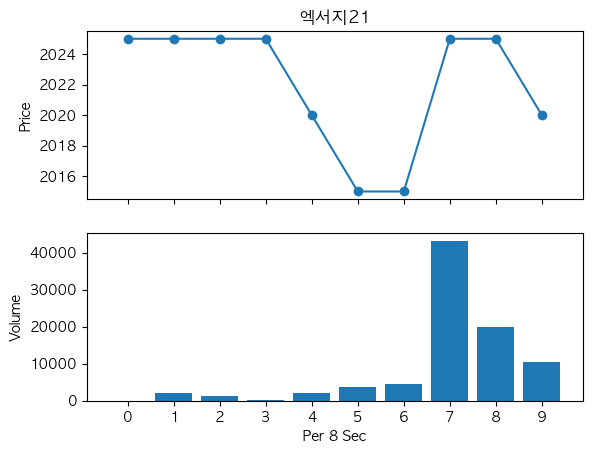

In [10]:
item = '043090'
ct.show_plot(item)